In [1]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np
import torchvision.transforms as T
import ast
#from lavis.models import load_model_and_preprocess
#import cuda

In [2]:
with torch.cuda.device(torch.device('cuda:4')): 
    info = torch.cuda.mem_get_info()
print(info[0] / info[1])
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device, device2)


0.9926922699652554
cuda:4 cuda:4


In [24]:
import modules

In [14]:
blip = modules.BLIPModel(gpu_number=3)

2023-12-23 12:46:42.275785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 12:46:42.275827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 12:46:42.277025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 12:46:43.496680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
blip.caption()

In [3]:
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        print(vlen)
        original_fps = video_reader.get_avg_fps()
        print(original_fps)
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video

In [4]:
video_id = 3489439407
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')
video.shape

1662
29.97002997002997


torch.Size([1663, 3, 480, 640])

In [5]:
import modules

In [6]:
siglip = modules.SiglipModel(gpu_number=3)

In [7]:
siglip.name

'siglip'

In [8]:
transform = T.ToPILImage()
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]

In [9]:
a = siglip.forward(images, query="Woman in blue with headphones")

TypeError: SiglipModel.forward() got an unexpected keyword argument 'query'

In [13]:
a

[<PIL.Image.Image image mode=RGB size=640x480>]

In [10]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

Image features shape:  torch.Size([167, 1152]) Text features shape:  torch.Size([1, 1152])


133/167


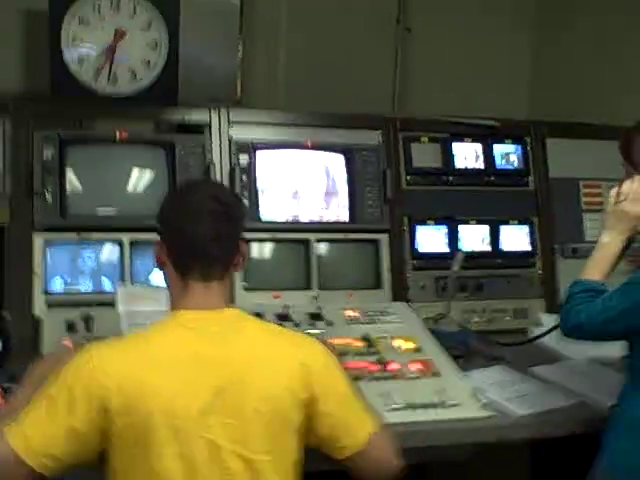

In [24]:
raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{len(images)}")
raw_image

In [46]:
blip.qa(raw_image, "ok")

['in the studio']

In [ ]:
from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
# ask a random question.
question = "What is the man doing in the video?"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

In [ ]:
import openai

with open('api.key') as f:
    openai.api_key = f.read().strip()
with open('api_org.key') as f:
    openai.organization = f.read().strip()

def call_llm(prompt):
    completion = openai.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Follow the directions given in the next prompt carefully."},
        {"role": "user", "content": prompt}
      ]
    )
    output_message = completion.choices[0].message.content
    return output_message


In [ ]:
def get_answer_helper(question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    with open('./prompts/base_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(answer_choices))
    prompt = prompt.replace('insert_curr_frame', str(curr_frame))
    prompt = prompt.replace('insert_total_frames', str(total_frames))
    prompt = prompt.replace('insert_caption', caption[0])

    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [ ]:
def final_select(question, choices, info):
    with open('./prompts/final_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(choices))
    prompt = prompt.replace('insert_info', str(info))
    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [ ]:
def query_VQA(vqa_question, frame):
    print("CALLING VQA: ", vqa_question)
    model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
    # ask a random question.
    question = vqa_question
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    question = txt_processors["eval"](question)
    answer = model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")
    print("VQA ANSWER: ", answer)
    return answer

In [ ]:
def query_caption(frame):
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    return caption

In [ ]:
def get_answer(images, question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    LIMIT = 10
    goto_frame = curr_frame
    VQA_question = None
    info = {}
    caption = caption
    while LIMIT >= 0:
        print(f"CALL {10 - LIMIT}")
        print("ALL INFO:", info)
        if f"Frame {goto_frame}" not in info:
            info[f"Frame {goto_frame}"] = {}
        LIMIT -= 1  
        if goto_frame != None:
            raw_image = images[goto_frame] 
        caption = query_caption(raw_image)
        print(caption)
        output = get_answer_helper(question, answer_choices, goto_frame, total_frames, caption, prev_info)
        print(output)
        if output["Answer"] != None:
            print("here1")
            return output["Answer"]
        else:
            info[f"Frame {goto_frame}"]["caption"] = caption
            if output["Choose Frame"] != None:
                goto_frame = output["Choose Frame"]
            if output["VQA Question"] != None:
                VQA_question = output["VQA Question"]
                vqa_result = query_VQA(VQA_question, raw_image)
                info[f"Frame {curr_frame}"][VQA_question] = vqa_result
            else:
                continue       
    # case for when we run out of tries
    final_output = final_select(question, answer_choices, info)
    return final_output

In [ ]:
def answer_question(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    return result

In [ ]:
def answer_question_half(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    return images, caption
    #result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    #return result

# Q1

In [12]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["bridge with water", "trail with trees", "skate park with people", "house with trees", "bed room with bed"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

raw_image = images[indices[0][0].item() - 150]


2697
29.97002997002997


In [13]:
indices

tensor([[265, 266, 260],
        [266, 265, 260],
        [223, 153, 151],
        [265, 266, 268],
        [268, 265,  37]], device='cuda:4')

In [14]:
print([idx for idx in range(3)])

[0, 1, 2]


In [18]:
raw_images = []
for i in range(len(options)):
    #raw_images.append([indices[i][idx] for idx in range(3)])
    #indices =[indices[i][idx] for idx in range(3)] 
    raw_images.append([images[num] for num in [indices[i][idx].item() for idx in range(3)]])


In [19]:
indices

tensor([[265, 266, 260],
        [266, 265, 260],
        [223, 153, 151],
        [265, 266, 268],
        [268, 265,  37]], device='cuda:4')

In [16]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["bridge with water", "trail with trees", "skate park with people", "house with trees", "bed room with bed"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{images.shape[0]}")

from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
caption = model.generate({"image": image})
print(caption)
raw_image

2697
29.97002997002997


KeyboardInterrupt: 

In [ ]:
result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
result

# Q2

In [ ]:
video_id = 4010069381
question = "why does the lady walks away after the conversation with man is over?"
options = ['pick up phone', 'enjoying stroll', 'giving her space to perform', 'help man do something else', 'performance ended']

images, caption = answer_question_half(video_id, question, options, "lady walking away")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q3

In [ ]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "location of the image")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q4

In [ ]:
video_id = 3489439407
question = "what are the two men doing as the lady in blue stands and listen via her headphone?"
options = ['turns around', 'working on the radio', 'moving the papers', 'walk forward', 'choosing a flower']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "lady in blue standing listening to her headphones")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q4

In [ ]:
video_id = 3814690167
question = "why did the man in glasses bounce up and down at the start of the video?"
options = ['warm up', 'supportive audience', 'clap to the beats', 'to show his passion for dancing', 'begin to sing']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "man in glasses bouncing up and down")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q5

In [ ]:
video_id = 11566980553
question = "how does the woman respond after the boy gives her the present?"
options = ['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "woman recieving present from boy")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

In [ ]:
final_select(question, options, {'Frame 3': {'caption': ['a young boy standing in a living room holding a nintendo wii controller'], 'What does the man do after the boy gives the present?': ['play wii'], "What is the woman's reaction to the boy's present?": ['happy'], "What is the woman's reaction to the boy's gift?": ['happy'], 'What is the woman doing in the video?': ['eating'], 'What are the kids doing on top of the couch?': ['playing'], 'What is happening in the video?': ['playing wii']}, 'Frame 150': {'caption': ['a young boy sitting on the floor reading a book']}, 'Frame 30': {'caption': ['a couple of kids sitting on top of a couch']}, 'Frame 133': {'caption': ['a young boy sitting on the floor holding a wii remote']}})

In [ ]:
"['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']",,how does the woman respond after the boy gives her the present?,1,11566980553.mp4

- Image level allows you to go back and forth in time, can't do in video-models
    - Binary search aspect -> start in middle -> move forward if not
    - Exponential or recursive
- Image level leveraging for video -> algorithm efficiency analysis
- Show that it works for multiple datasets
- List of different datasets other than NextQA

In [ ]:
import dataset

In [ ]:
dataset.get_data("queries_2k.csv")

# New Testing

In [3]:
import torch
for i in range(torch.cuda.device_count()):
    info = torch.cuda.get_device_properties(i)
    print("=======")
    print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))    
    print(f"CUDA:{i} {info.name}, {info.total_memory / 1024 ** 2}MB")

device = torch.device("cuda")

CUDA:0 NVIDIA GeForce RTX 3090, 24259.6875MB
CUDA:1 NVIDIA GeForce RTX 3090, 24259.6875MB
CUDA:2 NVIDIA GeForce RTX 3090, 24256.9375MB
CUDA:3 NVIDIA GeForce RTX 3090, 24259.6875MB
CUDA:4 NVIDIA GeForce RTX 3090, 24259.6875MB
CUDA:5 Quadro RTX 6000, 24212.375MB
CUDA:6 Quadro RTX 6000, 24212.375MB


In [ ]:
a = 5

In [1]:
import modules
from dataset import MyDataset

dict_keys(['multiprocessing', 'path_pretrained_models', 'execute_code', 'dataset', 'load_models', 'gpt', 'save', 'save_new_results', 'results_dir', 'use_cache', 'clear_cache', 'use_cached_codex', 'cached_codex_path', 'log_every', 'wandb', 'blip_half_precision', 'blip_v2_model_type', 'use_fixed_code', 'fixed_code_file'])
./prompts/base_prompt.txt


In [4]:
blip = modules.BLIPModel(gpu_number=6)
#siglip = modules.SiglipModel(gpu_number=5, siglip_model_type="ViT-B-16-SigLIP")

2023-12-26 12:54:07.363611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 12:54:07.363655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 12:54:07.364813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 12:54:08.919743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
dataset = MyDataset(data_path="/shared/shang/datasets/nextqa/videos/",
                    query_file="/shared/shang/datasets/nextqa/metadata/queries_2k.csv",
                    max_samples=10)

In [3]:
item = dataset[6]

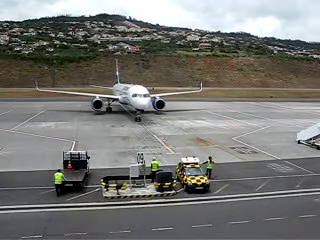

In [5]:
item["video"][6]

In [6]:
blip.forward(item["video"])

TypeError: 'NoneType' object is not iterable

In [ ]:
prompts_qa = [self.qa_prompt.format(self.pre_question(q)) for q, t in zip(question, task) if t == 'qa']

In [ ]:
keyframe = siglip.forward(images=item['video'], queries=["person near plane"])

In [32]:
from config import settings as config

In [48]:
llm = GPTModel()

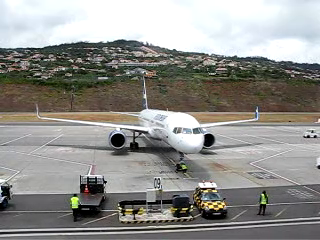

In [28]:
item["video"][1010]

In [53]:
prompt1 = f"you are looking at a video. given this question: 'why does the person go near the plane towards the end?' and the options: ['give signal to pilot', 'pick it up', 'on board', 'to assist', 'taking off']. you have access from the first frames of the video. they are captioned ['the person near the plane is looking at it',  ] "

In [58]:
llm.call_llm(prompt1)

'To answer the question "why does the person go near the plane towards the end?", you need to gather information from the video. Specifically, you should watch the video until the end to observe the actions of the person in question and determine the reason for their approach to the plane.'

In [73]:
item["video"][::10]

[<PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=32

In [76]:
from tqdm import tqdm
res = []
for i in tqdm(range(len(item["video"][::30]))):
    res.append(blip.qa(item["video"][::30][i], "what is the man doing in the image?"))
    

  0%|          | 0/42 [00:00<?, ?it/s]/home/shang/miniconda3/envs/vid_vqa/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 42/42 [00:20<00:00,  2.01it/s]


In [77]:
res

[['a large airplane on the tarmac'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a plane is parked on the tarmac'],
 ['a plane is parked on the tarmac'],
 ['a plane is parked at an airport'],
 ['a large jet airplane on the tarmac'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a plane is on the tarmac'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a jet is parked at an airport'],
 ['a plane is parked at an airport'],
 ['a jet is parked at an airport'],
 ['a jet is parked at an airport'],
 ['a jet plane is parked at an airport'],
 ['a jet is parked at an airport'],
 ['a jet is parked at an airport'],
 ['a jet is parked on the tarmac'],
 ['a jet is parked at an 

In [56]:
import openai
with open('api.key') as f:
    openai.api_key = f.read().strip()
with open('api_org.key') as f:
    openai.organization = f.read().strip()

In [47]:
from config import settings as config
class GPTModel():
    name = 'gpt3'
    to_batch = False
    requires_gpu = False

    def __init__(self, gpu_number=0):
        # TODO: modify the prompting mechanism
        with open("./prompts/base_prompt.txt") as f:
            self.qa_prompt = f.read().strip()
        self.temperature = config["gpt"]["temperature"]
        self.n_votes = config["gpt"]["n_votes"]
        self.model = config["gpt"]["model"]

    @staticmethod
    def call_llm(prompt):
        completion = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Follow the directions given in the next prompt carefully."},
            {"role": "user", "content": prompt}
        ]
        )
        output_message = completion.choices[0].message.content
        return output_message

    @staticmethod
    def get_answer_helper(self, question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
        with open('./prompts/base_prompt.txt') as f:
            prompt = f.read()
        prompt = prompt.replace('insert_question', question)
        prompt = prompt.replace('insert_choices', str(answer_choices))
        prompt = prompt.replace('insert_curr_frame', str(curr_frame))
        prompt = prompt.replace('insert_total_frames', str(total_frames))
        prompt = prompt.replace('insert_caption', caption[0])

        #print(prompt)
        output = self.call_llm(prompt)
        try:
            output_dict = ast.literal_eval(output)
            print("GETTING OUTPUT: ", output_dict)
            return output_dict
        except:
            print("ERROR: ", output)

    def final_select(self, question, choices, info):
        with open('./prompts/final_prompt.txt') as f:
            prompt = f.read()
        prompt = prompt.replace('insert_question', question)
        prompt = prompt.replace('insert_choices', str(choices))
        prompt = prompt.replace('insert_info', str(info))
        #print(prompt)
        output = self.call_llm(prompt)
        try:
            output_dict = ast.literal_eval(output)
            print("GETTING FINAL OUTPUT: ", output_dict)
            return output_dict
        except:
            print("ERROR: ", output)
            return output


    # initial cleaning for reference QA results
    @staticmethod
    def process_answer(answer):
        """Strips whitespace, periods, commas, and filler words"""
        answer = answer.lstrip()  # remove leading spaces (our addition)
        answer = answer.replace('.', '').replace(',', '').lower()
        to_be_removed = {'a', 'an', 'the', 'to', ''}
        answer_list = answer.split(' ')
        answer_list = [item for item in answer_list if item not in to_be_removed]
        return ' '.join(answer_list)

    @staticmethod
    def get_union(lists):
        return list(set(chain.from_iterable(lists)))

    @staticmethod
    def most_frequent(answers):
        """Returns the most frequent answer based on count"""
        answer_counts = Counter(answers)
        return answer_counts.most_common(1)[0][0]

    def get_qa(self, prompts, prompt_base: str=None) -> list[str]:
        if prompt_base is None:
            prompt_base = self.qa_prompt
        prompts_total = []
        for p in prompts:
            question = p
            prompts_total.append(prompt_base.format(question))
        response = self.get_qa_fn(prompts_total)
        if self.n_votes > 1:
            response_ = []
            for i in range(len(prompts)):
                if self.model == 'chatgpt':
                    resp_i = [r['message']['content']
                              for r in response['choices'][i * self.n_votes:(i + 1) * self.n_votes]]
                else:
                    resp_i = [r['text'] for r in response['choices'][i * self.n_votes:(i + 1) * self.n_votes]]
                response_.append(self.most_frequent(resp_i))
            response = response_
        else:
            if self.model == 'chatgpt':
                response = [r['message']['content'] for r in response['choices']]
            else:
                response = [self.process_answer(r["text"]) for r in response['choices']]
        return response

    def get_qa_fn(self, prompt):
        response = self.query_gpt3(prompt, model=self.model, max_tokens=5, logprobs=1, stream=False,
                                   stop=["\n", "<|endoftext|>"])
        return response

    def get_general(self, prompts) -> list[str]:
        if self.model == "chatgpt":
            raise NotImplementedError
        response = self.query_gpt3(prompts, model=self.model, max_tokens=256, top_p=1, frequency_penalty=0,
                                   presence_penalty=0)
        response = [r["text"] for r in response['choices']]
        return response

    def query_gpt3(self, prompt, model="text-davinci-003", max_tokens=16, logprobs=None, stream=False,
                   stop=None, top_p=1, frequency_penalty=0, presence_penalty=0):
        if model == "chatgpt":
            messages = [{"role": "user", "content": p} for p in prompt]
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=messages,
                max_tokens=max_tokens,
                temperature=self.temperature,
            )
        else:
            response = openai.Completion.create(
                model=model,
                prompt=prompt,
                max_tokens=max_tokens,
                logprobs=logprobs,
                temperature=self.temperature,
                stream=stream,
                stop=stop,
                top_p=top_p,
                frequency_penalty=frequency_penalty,
                presence_penalty=presence_penalty,
                n=self.n_votes,
            )
        return response

    def forward(self, prompt, process_name):
        if not self.to_batch:
            prompt = [prompt]
        
        if process_name == 'gpt3_qa':
            # if items in prompt are tuples, then we assume it is a question and context
            if isinstance(prompt[0], tuple) or isinstance(prompt[0], list):
                prompt = [question.format(context) for question, context in prompt]

        to_compute = None
        results = []
        if len(prompt) > 0:
            if process_name == 'gpt3_qa':
                response = self.get_qa(prompt)
            else:  # 'gpt3_general', general prompt, has to be given all of it
                response = self.get_general(prompt)
        else:
            response = []  # All previously cached

        results = response

        if not self.to_batch:
            results = results[0]
        return results